In [14]:
import itertools as it
import time
from utils import *

import numpy as np
from scipy import sparse

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

import matplotlib.pyplot as plt


In [15]:
class GCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = GCNConv(node_features, 64)
        self.conv2 = GCNConv(64, 128)
        # self.conv1 = GATConv(node_features, 64, 5)
        # self.conv2 = GATConv(64 * 5, 128)
        # self.conv3 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.elu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # x = F.tanh(x)
        # x = self.conv3(x, edge_index)

        return x


(array([   0,    0,    0, ..., 2243, 2243, 2243]), array([   3,    4,   14, ..., 2237, 2239, 2241]))
tensor([[   0,    0,    0,  ..., 2243, 2243, 2243],
        [   3,    4,   14,  ..., 2237, 2239, 2241]])
[1. 1. 1. ... 4. 4. 4.]
histogram of original weight: (array([13550,  3892,  1276,   300,    36,    16]), array([1, 2, 3, 4, 5, 6, 7]))


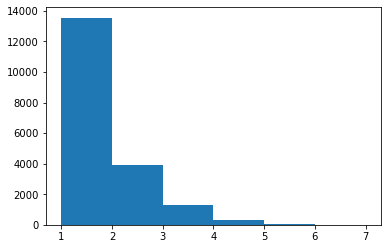

[1. 1. 1. ... 4. 4. 4.]


In [16]:
sat_name = 'countbitsrotate016.processed.cnf'

sat_path = f'./dataset/train_formulas/{sat_name}'
num_vars, num_clauses, sat_instance = read_sat(sat_path)
max_len = max([len(clause) for clause in sat_instance])

lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
print(lig_adjacency_matrix.nonzero())


# graph = nx.from_numpy_matrix(lig_adjacency_matrix)
# edges = nx.to_edgelist(graph)
# print(lig_adjacency_matrix.nonzero())

edge_index = torch.tensor(lig_adjacency_matrix.nonzero(), dtype=torch.long)
print(edge_index)
edge_value = lig_weighted_adjacency_matrix[lig_adjacency_matrix.nonzero()]
print(edge_value)
print(f'histogram of original weight: {np.histogram(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])}')
plt.hist(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])
plt.show()
# max_edge_value = max(edge_value)
# norm_edge_value = edge_value/max_edge_value
norm_edge_value = edge_value
print(norm_edge_value)

embeddings = torch.load(f'./model/embeddings/{sat_name}.pt')
embeddings.requires_grad = False
# print(embeddings)
x = embeddings
data = Data(x=x, edge_index=edge_index)


In [17]:
# training
model = GCN(50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    src, dst = edge_index
    score = (out[src] * out[dst]).sum(dim=-1)
    # score = torch.sigmoid(score)
    loss = F.mse_loss(score, torch.tensor(norm_edge_value, dtype=torch.float))
    loss.backward()
    optimizer.step()
    # print(f'epoch: {epoch}, loss: {loss.item()}')

out = model(data)
src, dst = edge_index
score = (out[src] * out[dst]).sum(dim=-1)
# print(min(score))
# score = torch.sigmoid(score)
print(f"norm_edge_value: {norm_edge_value}")
print(f"score: {score.detach()}")
print(f"min score: {min(score)}")
print(f"max score: {max(score)}")

norm_edge_value: [1. 1. 1. ... 4. 4. 4.]
score: tensor([1.1290, 1.2960, 1.1794,  ..., 3.6373, 3.6078, 3.5742])
min score: -0.3806247115135193
max score: 3.6737771034240723


In [18]:
# CELL
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics


sparse_matrix = sparse.csr_matrix(lig_adjacency_matrix)
cell_model = Cell(A=sparse_matrix,
             H=10,
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.75)])


cell_model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})


Step:  10/200 Loss: 5.86534 Edge-Overlap: 0.079 Total-Time: 1
Step:  20/200 Loss: 4.29879 Edge-Overlap: 0.311 Total-Time: 2
Step:  30/200 Loss: 3.65459 Edge-Overlap: 0.439 Total-Time: 3
Step:  40/200 Loss: 3.28169 Edge-Overlap: 0.513 Total-Time: 5
Step:  50/200 Loss: 3.05807 Edge-Overlap: 0.585 Total-Time: 6
Step:  60/200 Loss: 2.91035 Edge-Overlap: 0.632 Total-Time: 7
Step:  70/200 Loss: 2.80709 Edge-Overlap: 0.670 Total-Time: 9
Step:  80/200 Loss: 2.73257 Edge-Overlap: 0.712 Total-Time: 10
Step:  90/200 Loss: 2.67829 Edge-Overlap: 0.736 Total-Time: 11
Step: 100/200 Loss: 2.63830 Edge-Overlap: 0.755 Total-Time: 12


In [19]:
generated_graph = cell_model.sample_graph()
graph_prime = generated_graph.A
graph_prime = graph_post_process(graph_prime)
# print('here is graph_prime')
# print(graph_prime[graph_prime < 0])
# print(len(graph_prime))
# print(graph_prime)
# print(graph_prime[[0, 1, 2], [0, 0, 0]])

edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
x = embeddings
data_prime = Data(x=x, edge_index = edge_index_prime)
out = model(data_prime)
src, dst = edge_index_prime
score = (out[src] * out[dst]).sum(dim=-1)
weight = score.detach().numpy()
weight[weight <= 1] = 1
weight = np.rint(weight).astype(int)


# print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
# plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

weighted_graph_prime = np.copy(graph_prime)
weighted_graph_prime[weighted_graph_prime.nonzero()] = weight
# lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
clique_candidates = get_clique_candidates(graph_prime, max_len)
print(weighted_graph_prime.shape)

current_cliques = lazy_clique_edge_cover(np.copy(weighted_graph_prime), clique_candidates, num_clauses)
current_sat = cliques_to_sat(current_cliques)

(2244, 2244)


In [20]:
features = [
        "clu. VIG",
        "clu. LIG",
        "mod. VIG",
        "mod. LIG",
        "mod. VCG",
        "mod. LCG"
]

metrics = eval_solution(current_sat, num_vars)
for feature, value in zip(features, metrics):
    print(f'{feature}: {value}')

clu. VIG: 0.34441802048711934
clu. LIG: 0.2740933830026138
mod. VIG: 0.56953069041614
mod. LIG: 0.6251773505975493
mod. VCG: 0.748425366164442
mod. LCG: 0.5961273941413487


In [21]:
# init_lig = lig_adjacency_matrix
# generate_lig = graph_prime
# init_wlig = lig_weighted_adjacency_matrix
# generate_wlig = weighted_graph_prime
# formulas_lig, formulas_wlig = sat_to_lig_adjacency_matrix(current_sat, num_vars)



In [22]:
# import csv

# graphs = [init_lig, generate_lig, init_wlig, generate_wlig, formulas_wlig]
# graph_names = ['init_lig', 'generate_lig', 'init_wlig', 'generate_wlig', 'formulas_wlig']

# fileds = ['Source','Target','Type','Kind','Id','Label','Weight']
# with open('ssa2670-141-all-1.csv', 'w') as csvfile:
#     csvwriter = csv.writer(csvfile, delimiter=',')
#     csvwriter.writerow(fileds)
#     idx = 1
#     for graph_name, graph in zip(graph_names, graphs):
#         triu_adjacency_matrix = np.triu(graph)
#         x, y = triu_adjacency_matrix.nonzero()
#         for i, j in zip(x, y):
#             csvwriter.writerow([i, j, 'Undirected', graph_name, idx, graph_name, triu_adjacency_matrix[i][j]])
#             idx += 1
    

In [23]:
# generate_num = 50

# start_time = time.time()
# for idx in range(generate_num):
#     # print(idx)
#     generated_graph = cell_model.sample_graph()
#     graph_prime = generated_graph.A
#     graph_prime = graph_post_process(graph_prime)
#     # print(len(graph_prime))
#     # print(graph_prime)
#     # print(graph_prime[[0, 1, 2], [0, 0, 0]])

#     edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
#     data_prime = Data(x=x, edge_index = edge_index_prime)
#     out = model(data_prime)
#     src, dst = edge_index_prime
#     score = (out[src] * out[dst]).sum(dim=-1)
#     weight = score.detach().numpy()
#     weight[weight <= 1] = 1
#     weight = np.rint(weight).astype(int)
#     # print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
#     # plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

#     weighted_graph_prime = graph_prime
#     weighted_graph_prime[weighted_graph_prime.nonzero()] = weight
#     # lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
#     max_len = 8
#     clique_candidates = get_clique_candidates(graph_prime, max_len)
#     num_clauses = 377
#     num_vars = 91
#     # print(weighted_graph_prime.shape)
#     current_clique_idxs = lazy_clique_edge_cover(weighted_graph_prime, clique_candidates, num_clauses, num_vars)
#     current_cliques = [clique_candidates[idx] for idx in current_clique_idxs]
#     current_sat = cliques_to_sat(current_cliques)

#     path = f"./eval_formulas/ssa2670-141/generating-sat-{idx}.cnf"
#     with open(path, 'w') as f:
#         f.write('p cnf 91 377\n')
#         for clause in current_sat:
#             f.write(f"{' '.join([str(v) for v in clause])} 0\n")

# print(f'generating {generate_num} instances with time {time.time() - start_time}')

# Todo

- Optimize the optimal weighted coverage (OWC) algorithm
- Generate more graph for the ssa2670, compute the average metric
- Test the method on more instances
- *Test the solver performance*